In [34]:
import pandas as pd

df = pd.read_csv("data/weather_data.csv")
timestamp=200

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# 데이터 분할
X = df.drop(["date"], axis=1)

# 50일치 데이터를 보고 1일치 데이터를 예측하는 데이터셋 생성
def create_dataset(X, time_steps=timestamp):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(X.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 50
X_train, y_train = create_dataset(X, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [36]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# 50일치 데이터를 보고 다음 날의 10열 데이터를 예측하는 모델이므로
# input_size는 50 * 10 (50일 * 10개의 특성), output_size는 10 (다음 날의 10개 특성)입니다.
input_size =  10
output_size = 10

model = LSTM(input_size, 64, 2, output_size)

# 모델 컴파일
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [37]:
# 모델 학습
num_epochs=100
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 10))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

Epoch [1/100], Step [10/100], Loss: 27690.3535
Epoch [1/100], Step [20/100], Loss: 30383.6133
Epoch [1/100], Step [30/100], Loss: 25141.2461
Epoch [1/100], Step [40/100], Loss: 28503.9570
Epoch [1/100], Step [50/100], Loss: 24556.3223
Epoch [1/100], Step [60/100], Loss: 21439.1719
Epoch [1/100], Step [70/100], Loss: 16252.5107
Epoch [1/100], Step [80/100], Loss: 15277.6045
Epoch [1/100], Step [90/100], Loss: 15695.2480
Epoch [1/100], Step [100/100], Loss: 16877.7930
Epoch [2/100], Step [10/100], Loss: 16656.6055
Epoch [2/100], Step [20/100], Loss: 19498.1230
Epoch [2/100], Step [30/100], Loss: 4512.2695
Epoch [2/100], Step [40/100], Loss: 14720.9531
Epoch [2/100], Step [50/100], Loss: 8080.3857
Epoch [2/100], Step [60/100], Loss: 9315.1416
Epoch [2/100], Step [70/100], Loss: 8115.3423
Epoch [2/100], Step [80/100], Loss: 6439.4390
Epoch [2/100], Step [90/100], Loss: 8199.6143
Epoch [2/100], Step [100/100], Loss: 5325.1523
Epoch [3/100], Step [10/100], Loss: 6603.2720
Epoch [3/100], Step

In [38]:
# 학습 함수
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# 평가 함수
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output.squeeze(), target)
            running_loss += loss.item()
    return running_loss / len(test_loader)

# 학습 및 평가
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [1/200], Train Loss: 4520.0389, Test Loss: 4845.8876
Epoch [2/200], Train Loss: 4553.6652, Test Loss: 4916.6949
Epoch [3/200], Train Loss: 4569.2329, Test Loss: 4949.2640
Epoch [4/200], Train Loss: 4490.8276, Test Loss: 4868.0458
Epoch [5/200], Train Loss: 4562.1325, Test Loss: 4897.9075
Epoch [6/200], Train Loss: 4546.9130, Test Loss: 4873.5757
Epoch [7/200], Train Loss: 4455.0167, Test Loss: 4932.0021
Epoch [8/200], Train Loss: 4529.5560, Test Loss: 4998.5437
Epoch [9/200], Train Loss: 4546.1587, Test Loss: 4906.2231
Epoch [10/200], Train Loss: 4437.0058, Test Loss: 4872.6504
Epoch [11/200], Train Loss: 4504.4851, Test Loss: 4919.4078
Epoch [12/200], Train Loss: 4449.9079, Test Loss: 4852.1565
Epoch [13/200], Train Loss: 4409.1282, Test Loss: 4989.0478
Epoch [14/200], Train Loss: 4468.2087, Test Loss: 4925.6356
Epoch [15/200], Train Loss: 4512.3167, Test Loss: 5026.2790
Epoch [16/200], Train Loss: 4480.5114, Test Loss: 5050.2809
Epoch [17/200], Train Loss: 4495.8380, Test Loss:

tensor([[[ 1.2400e+01, -3.2000e+00,  4.0300e+01,  ...,  9.1000e+00,
           5.7300e+02,  1.0600e+01],
         [ 1.4600e+01, -3.1000e+00,  4.3000e+01,  ...,  9.0000e+00,
           5.8200e+02,  1.0500e+01],
         [ 1.6200e+01, -9.0000e-01,  5.5000e+01,  ...,  7.7000e+00,
           5.8900e+02,  1.0900e+01],
         ...,
         [ 9.6000e+00, -5.3000e+00,  5.1300e+01,  ...,  3.5000e+00,
           0.0000e+00, -5.0000e-01],
         [ 3.2000e+00,  1.0000e+00,  9.6100e+01,  ...,  1.4000e+00,
           7.7800e+02,  0.0000e+00],
         [ 5.9000e+00, -1.0000e+00,  6.2800e+01,  ...,  3.3000e+00,
           6.4500e+02,  1.0000e-01]],

        [[ 1.3600e+01, -1.7000e+00,  4.3300e+01,  ...,  1.1200e+01,
           3.7100e+02,  8.5000e+00],
         [ 1.7800e+01, -6.0000e-01,  2.8000e+01,  ...,  1.2800e+01,
           5.2400e+02,  9.8000e+00],
         [ 2.1400e+01,  2.8000e+00,  2.6500e+01,  ...,  1.2900e+01,
           2.8900e+02,  1.2600e+01],
         ...,
         [ 2.5000e+01,  1

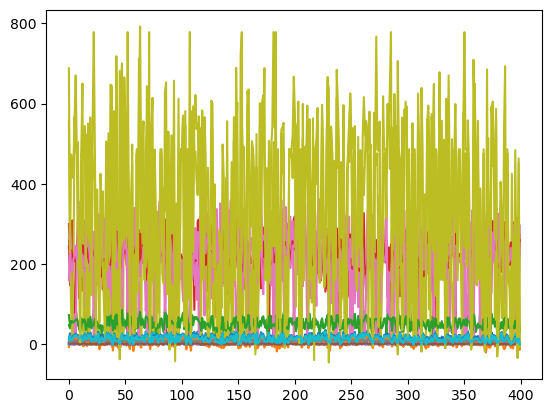

In [39]:
# 예측
model.eval()
with torch.no_grad():
    inputs = X_test
    print(inputs)
    print(inputs.shape)
    outputs = model(inputs)
    predicted = torch.round(outputs)
    
# 예측 결과를 시각화
import matplotlib.pyplot as plt
plt.plot(y_test, label="True")
plt.plot(predicted, label="Predicted")
plt.show()

In [43]:
# 최근 날짜로부터 200일까지의 데이터를 모아서 그 다음날 예측하기
for _ in range(365):
    df = pd.read_csv("data/weather_data.csv")
    df.tail(timestamp) # 해당 데이터에서 date와 target열을 제거한 다음, 50일치 데이터를 (1,50,10)형태로 갖고오기
    last_50 = df.tail(timestamp).drop(["date"], axis=1)
    last_50 = torch.FloatTensor(last_50.values).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        output = model(last_50)
        print(output)

    #df에 예측값 추가하기
    # df["date"].iloc[-1]을 date 타입으로 변환
    df["date"] = pd.to_datetime(df["date"])
    next_date = df["date"].iloc[-1] + pd.DateOffset(days=1)
    
    # max_Temp,min_Temp,hum,widdir,wind,rain,sun_Time,sun_Qy,condens_Time,soil_Temp 이름으로 11개의 열을 가진 행 생성
    new_row = pd.DataFrame({
        "date": [next_date],
        "max_Temp": [output[0][0].item()],
        "min_Temp": [output[0][1].item()],
        "hum": [output[0][2].item()],
        "widdir": [output[0][3].item()],
        "wind": [output[0][4].item()],
        "rain": [output[0][5].item()],
        "sun_Time": [output[0][6].item()],
        "sun_Qy": [output[0][7].item()],
        "condens_Time": [output[0][8].item()],
        "soil_Temp": [output[0][9].item()]
    })
    
    
    #new_row = pd.DataFrame({"date": [next_date], "max_Temp": [output.item()]})
    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv("data/weather_data.csv", index=False)

tensor([[ 14.2229,   0.7815,  43.4623, 239.3244,   1.5972,  -0.7873, 251.5585,
           8.9759, 121.2107,  10.3288]])
tensor([[ 16.3043,   5.3080,  55.4573, 211.9966,   1.2337,   1.2746, 185.6048,
           7.6503, 297.3289,  12.9407]])
tensor([[ 12.9177,   4.9879,  56.0455, 188.1128,   1.1226,   2.0004, 126.8065,
           5.2447, 297.7020,  10.8353]])
tensor([[ 12.3508,   4.2738,  67.8191, 218.6839,   1.0462,   3.3522, 126.6961,
           4.5160, 506.4391,  10.2480]])
tensor([[ 13.4978,   2.9383,  63.4699, 250.3910,   1.1405,   2.2152, 193.3096,
           5.9919, 481.1601,  10.7577]])
tensor([[ 13.1336,   1.1494,  55.3883, 258.7482,   1.3416,   0.7829, 229.6811,
           7.0193, 339.0017,  10.0035]])
tensor([[ 10.1539,  -1.8177,  46.4985, 257.1670,   1.8850,  -0.3976, 235.6266,
           7.5384,   9.1641,   7.4891]])
tensor([[1.0263e+01, 1.1224e-01, 4.5915e+01, 2.2233e+02, 1.4762e+00, 1.1145e-01,
         1.8901e+02, 6.1654e+00, 1.0708e+02, 7.8122e+00]])
tensor([[1.0546e+01,

In [41]:
df

,date,max_Temp,min_Temp,hum,widdir,wind,rain,sun_Time,sun_Qy,condens_Time,soil_Temp
0,2017-01-01 13:00:00,6.100000,-6.300000,66.700000,148.500000,0.5000,0.000000,232.000000,4.200000,755.000000,0.600000
1,2017-01-02 13:00:00,7.800000,-5.900000,66.500000,175.100000,0.6000,0.000000,118.000000,4.000000,697.000000,0.700000
2,2017-01-03 13:00:00,6.500000,-4.100000,41.800000,306.600000,2.5000,0.000000,254.000000,5.900000,637.000000,0.800000
3,2017-01-04 13:00:00,8.100000,-5.400000,60.800000,293.900000,1.4000,0.000000,241.000000,5.400000,479.000000,0.900000
4,2017-01-05 13:00:00,7.700000,-4.800000,65.400000,186.100000,1.6000,0.000000,29.000000,3.000000,464.000000,1.100000
...,...,...,...,...,...,...,...,...,...,...,...
2408,2026-05-06 13:00:00,5.740489,-5.783971,24.490168,205.077515,1.7393,-0.479717,232.201538,6.846423,5.324981,2.471413
2409,2026-05-07 13:00:00,5.740489,-5.783971,24.490166,205.077515,1.7393,-0.479717,232.201538,6.846424,5.324978,2.471413
2410,2026-05-08 13:00:00,5.740489,-5.783970,24.490168,205.077515,1.7393,-0.479717,232.201538,6.846423,5.324975,2.471413
2411,2026-05-09 13:00:00,5.740489,-5.783971,24.490168,205.077515,1.7393,-0.479717,232.201523,6.846423,5.324968,2.471413


In [42]:
# 해당 df의 마지막 날짜 뽑아오기
last_date = df["date"].iloc[-1]
# 13:00 제거
last_date = last_date.split(" ")[0]

AttributeError: 'Timestamp' object has no attribute 'split'

In [ ]:
#last_date에서 1일을 더한 날짜 출력
from datetime import datetime, timedelta
last_date = datetime.strptime(last_date, "%Y-%m-%d")
next_date = last_date + timedelta(days=1)
next_date = next_date.strftime("%Y-%m-%d")
print(next_date)

2024-01-31
